In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm
import missingno as mno

# Load the data

In [2]:
data = pd.read_excel('dataset.xlsx')

# Data Preprocessing and Cleaning

In [3]:
data = data.rename(columns = {'sex(man=1,woman=0)':'sex', 'neck circumference（cm）':'neck', 
                       'waist circumference（cm）':'waist', 
                       'maximum interincisal distance（cm）':'mid', 'Mallampati test':'Mt', 
                       'ratio of Height to thyro-sternum distance':'rhtd', 
                       'ESS questionnaire':'ESS', 'STOP-Bang questionnaire':'SB', 
                       'no or mild OSA: moderate-severe OSA(0:1)':'result'})

In [4]:
#去除NaN
data[['sex', 'age', 'neck', 'waist', 'BMI', 'mid', 'Mt', 'rhtd']].isnull().sum()

sex      0
age      0
neck     0
waist    0
BMI      0
mid      2
Mt       0
rhtd     0
dtype: int64

In [5]:
missing_columns = ['mid']

In [6]:
def random_imputation(df, feature):
    
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace=True)
    
    return df
for feature in missing_columns:
    data[feature + "_imp"] = data[feature]
    data = random_imputation(data, feature)
deter_data = pd.DataFrame(columns=["Det" + name for name in missing_columns])

for feature in missing_columns:
    
    deter_data["Det" + feature] = data[feature + "_imp"]
    parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = data[parameters], y= data[feature + "_imp"])
    
    #Preserve the index of the missing data from the original dataframe
    deter_data.loc[data[feature].isnull(), "Det" + feature] = model.predict(data[parameters])[data[feature].isnull()]

In [7]:
random_data = pd.DataFrame(columns= ["Ran" + name for name in missing_columns])

for feature in missing_columns:
    
    random_data["Ran" + feature] = data[feature + "_imp"]
    parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = data[parameters], y=data[feature + '_imp'])
    
    #Standard error for the regression estimates is equal to std() of the errors of each estimate
    predict = model.predict(data[parameters])
    std_error = (predict[data[feature].notnull()] - data.loc[data[feature].notnull(), feature + '_imp']).std()
    
    #Preserve the index of the missing data from the original dataframe
    random_predict = np.random.normal(size = data[feature].shape[0],
                                      loc = predict,
                                      scale = std_error)
    random_data.loc[(data[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(data[feature].isnull()) & (random_predict > 0)]

<AxesSubplot:>

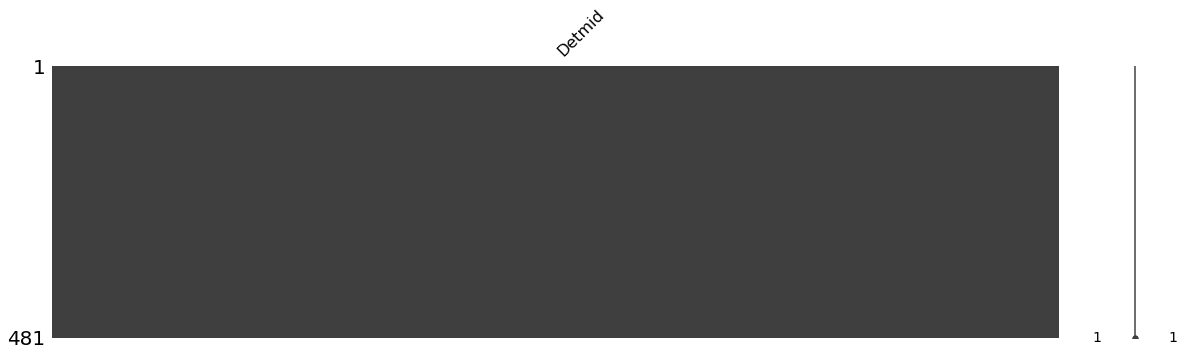

In [8]:
mno.matrix(deter_data, figsize=(20, 5))

In [9]:
data= pd.concat([data[['sex', 'age', 'neck', 'waist', 'BMI', 'Mt', 'rhtd', 'result']], deter_data[['Detmid']]], axis = 1)
data

,sex,age,neck,waist,BMI,Mt,rhtd,result,Detmid
0,1,37,38.0,83.0,22.491349,1,15.454545,0,6.0
1,1,31,40.0,89.0,22.093170,3,19.777778,0,5.0
2,1,43,37.0,86.0,22.491349,1,18.888889,0,6.0
3,1,30,37.0,89.0,23.255019,1,15.545455,0,6.0
4,1,53,39.0,99.0,27.335640,1,18.888889,0,5.0
...,...,...,...,...,...,...,...,...,...
476,0,69,32.0,86.0,21.258503,2,18.666667,0,4.0
477,0,62,34.5,85.0,24.464602,2,18.111111,1,5.0
478,0,61,34.0,76.0,24.609375,1,20.000000,1,5.5
479,0,63,36.0,83.0,19.467401,1,18.333333,1,6.0


# Modelling

## RandomForestClassifier

In [10]:
X = data[['sex', 'Mt', 'Detmid', 'age', 'neck', 'waist', 'BMI', 'rhtd']]
y = data['result']
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)
#RandomForestClassifier
model1 = RandomForestClassifier()
model1.fit(X_trn, y_trn)

RandomForestClassifier()

In [11]:
y_pred1 = model1.predict(X_tst)
matrix1 = confusion_matrix(y_tst,y_pred1)
confusion_matrix(y_tst, y_pred1)

array([[26,  7],
       [ 8, 56]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

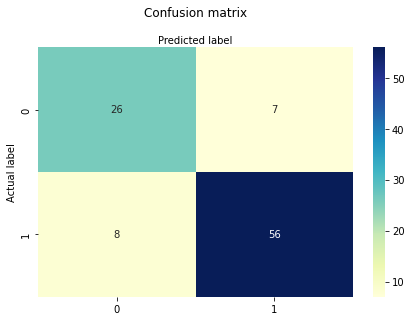

In [12]:
#混淆矩陣視覺化(Heatmap)
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [13]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred1, average =
'macro' )))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred1, average =
'micro')))
print(metrics.classification_report(y_tst, y_pred1))
print(metrics.confusion_matrix(y_tst, y_pred1))

Macro-average: 0.829004583382301
Micro-average: 0.845360824742268
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        33
           1       0.89      0.88      0.88        64

    accuracy                           0.85        97
   macro avg       0.83      0.83      0.83        97
weighted avg       0.85      0.85      0.85        97

[[26  7]
 [ 8 56]]


## ExtraTreesClassifier

In [14]:
model2 = ExtraTreesClassifier()
model2.fit(X_trn, y_trn)

ExtraTreesClassifier()

In [15]:
y_pred2 = model2.predict(X_tst)
matrix2 = confusion_matrix(y_tst,y_pred2)
confusion_matrix(y_tst, y_pred2)

array([[26,  7],
       [ 9, 55]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

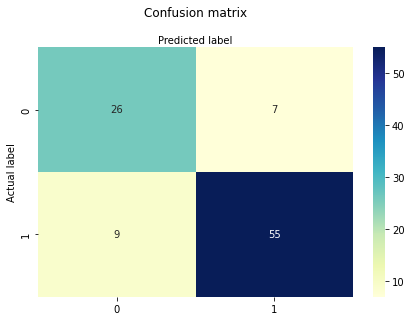

In [16]:
#混淆矩陣視覺化(Heatmap)
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [17]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred2, average =
'macro' )))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred2, average =
'micro')))
print(metrics.classification_report(y_tst, y_pred2))
print(metrics.confusion_matrix(y_tst, y_pred2))

Macro-average: 0.8188608776844071
Micro-average: 0.8350515463917526
              precision    recall  f1-score   support

           0       0.74      0.79      0.76        33
           1       0.89      0.86      0.87        64

    accuracy                           0.84        97
   macro avg       0.81      0.82      0.82        97
weighted avg       0.84      0.84      0.84        97

[[26  7]
 [ 9 55]]


## BaggingClassifier

# Feature Selection

In [18]:
X = data[['sex', 'age', 'neck', 'waist', 'BMI', 'Detmid', 'Mt', 'rhtd']]
y = data['result']

### Univariate

In [19]:
#Select the best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X ,y)
dfscore = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscore], axis=1)
featureScores.columns = ['Features', 'Score'] #naming the dataframe columns
print(featureScores.nlargest(8, 'Score')) #print 5 best features

  Features      Score
1      age  59.504241
3    waist  53.964149
7     rhtd  28.450988
2     neck  13.594773
4      BMI  11.748331
0      sex   6.823036
6       Mt   1.705740
5   Detmid   0.800208


### Feature importance

[0.04691032 0.144567   0.13266482 0.15850079 0.1503282  0.10404982
 0.06202812 0.20095092]


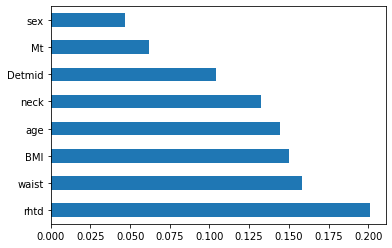

In [20]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind ='barh')
plt.show()

[0.03338407 0.14516153 0.12033986 0.16952075 0.16546933 0.07692362
 0.04305624 0.24614461]


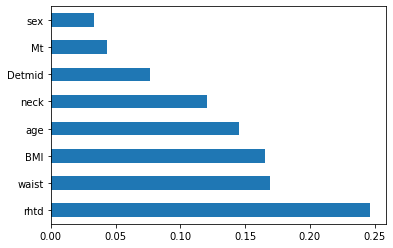

In [21]:
rf_model = RandomForestClassifier()
rf_model.fit(X, y)
print(rf_model.feature_importances_)
feat_importances = pd.Series(rf_model.feature_importances_, index = X.columns)
feat_importances.nlargest(8).plot(kind = 'barh')
plt.show()

### Correlation Matrix with Heatmap

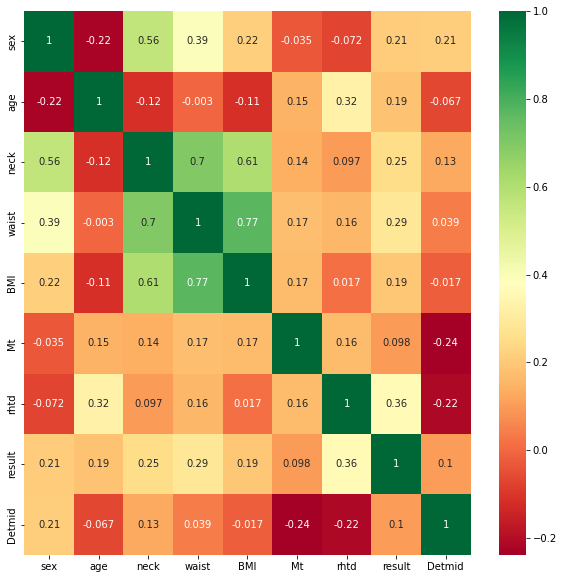

In [22]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10, 10))
# Plot heat map
g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [23]:
bagging = BaggingClassifier(RandomForestClassifier(), n_estimators=10)
bagging.fit(X_trn, y_trn)

BaggingClassifier(base_estimator=RandomForestClassifier())

In [24]:
y_pred3 = bagging.predict(X_tst)
matrix3 = confusion_matrix(y_tst,y_pred3)
confusion_matrix(y_tst, y_pred2)

array([[26,  7],
       [ 9, 55]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

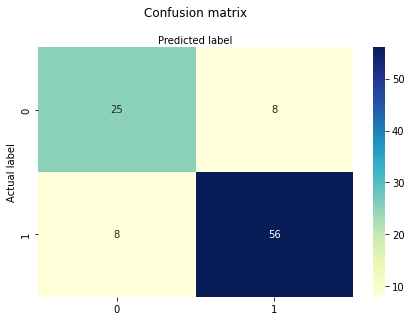

In [25]:
#混淆矩陣視覺化(Heatmap)
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix3), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [26]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred3, average =
'macro' )))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred3, average =
'micro')))
print(metrics.classification_report(y_tst, y_pred3))
print(metrics.confusion_matrix(y_tst, y_pred3))

Macro-average: 0.8162878787878788
Micro-average: 0.8350515463917526
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        33
           1       0.88      0.88      0.88        64

    accuracy                           0.84        97
   macro avg       0.82      0.82      0.82        97
weighted avg       0.84      0.84      0.84        97

[[25  8]
 [ 8 56]]


# Tuning

In [27]:
X = data[['sex', 'Mt', 'Detmid', 'age', 'neck', 'waist', 'BMI', 'rhtd']]
y = data['result']
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)
#RandomForestClassifier
model1 = RandomForestClassifier(n_estimators= 3000)
model1.fit(X_trn, y_trn)

RandomForestClassifier(n_estimators=3000)

In [28]:
y_pred1 = model1.predict(X_tst)
matrix1 = confusion_matrix(y_tst,y_pred1)
confusion_matrix(y_tst, y_pred1)

array([[25,  8],
       [ 7, 57]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

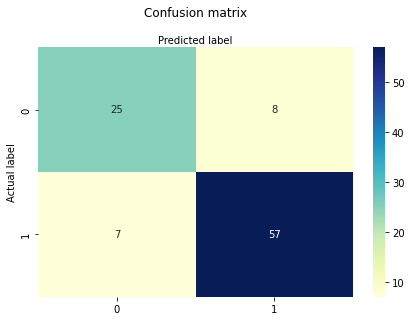

In [29]:
#混淆矩陣視覺化(Heatmap)
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [30]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred1, average =
'macro' )))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred1, average =
'micro')))
print(metrics.classification_report(y_tst, y_pred1))
print(metrics.confusion_matrix(y_tst, y_pred1))

Macro-average: 0.8264758497316635
Micro-average: 0.845360824742268
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        33
           1       0.88      0.89      0.88        64

    accuracy                           0.85        97
   macro avg       0.83      0.82      0.83        97
weighted avg       0.84      0.85      0.84        97

[[25  8]
 [ 7 57]]
